# Hamiltonian Monte Carlo with leapfrog

Scalar version: https://github.com/genkuroki/public/blob/main/0018/HMC%20leapfrog.ipynb

In [1]:
module My

using ConcreteStructs: @concrete
using Parameters: @unpack

using LinearAlgebra: dot
using ForwardDiff: gradient
using Random: default_rng, randn!
using StaticArrays: SVector, MVector

@concrete struct LFProblem{dim} ϕ; H; F; dt; nsteps end

"""Assume ϕ is a potential function."""
function LFProblem(dim, ϕ; dt = 1.0, nsteps = 40)
    H(x, v, param) = dot(v, v)/2 + ϕ(x, param)
    F(x, param) = -gradient(x -> ϕ(x, param), x)
    LFProblem{dim}(ϕ, H, F, dt, nsteps)
end

"""Assume ϕ is a potential function and ∇ϕ its gradient."""
function LFProblem(dim, ϕ, ∇ϕ; dt = 1.0, nsteps = 40)
    H(x, v, param) = dot(v, v)/2 + ϕ(x, param)
    F(x, param) = -∇ϕ(x, param)
    LFProblem{dim}(ϕ, H, F, dt, nsteps)
end

"""Numerically solve Hamilton's equation of motion with leapfrog method"""
function solve(lf::LFProblem, x, v, param)
    @unpack F, dt, nsteps = lf
    v = v + F(x, param)*dt/2
    x = x + v*dt
    for _ in 2:nsteps
        v = v + F(x, param)*dt
        x = x + v*dt
    end
    v = v + F(x, param)*dt/2
    x, v
end

@inline function _update!(lf::LFProblem{dim}, x, vtmp, param, rng) where dim
    @unpack H = lf
    v = SVector{dim}(randn!(rng, vtmp))
    xnew, vnew = solve(lf, x, v, param)
    dH = H(xnew, vnew, param) - H(x, v, param)
    alpha = min(1, exp(-dH))
    rand(rng) ≤ alpha ? xnew : x
end

"""Hamiltonian Monte Carlo"""
function HMC(lf::LFProblem{dim}, param = nothing;
        niters = 10^5, thin = 1, nwarmups = 0, rng = default_rng(),
        init = SVector{dim}(randn(rng, dim))) where dim
    vtmp = MVector{dim}(zeros(eltype(init), dim))
    x = init
    for _ in 1:nwarmups
        x = _update!(lf, x, vtmp, param, rng)
    end
    sample = Vector{typeof(init)}(undef, niters)
    for i in 1:niters
        for _ in 1:thin
            x = _update!(lf, x, vtmp, param, rng)
        end
        @inbounds sample[i] = x
    end
    sample
end

end

Main.My

In [2]:
using Plots
using BenchmarkTools
using StaticArrays
using LinearAlgebra
using KernelDensity
using Statistics
using QuadGK
using Distributions
using Symbolics

## 2-dimensional normal distribution

In [3]:
A = @SMatrix [
     1  1/2
    1/2  1
]
param = (; A = A)
ϕ(x, param) = dot(x, param.A, x)/2
lf = My.LFProblem(2, ϕ)

Main.My.LFProblem{2, typeof(ϕ), Main.My.var"#H#3"{typeof(ϕ)}, Main.My.var"#F#4"{typeof(ϕ)}, Float64, Int64}(ϕ, Main.My.var"#H#3"{typeof(ϕ)}(ϕ), Main.My.var"#F#4"{typeof(ϕ)}(ϕ), 1.0, 40)

In [4]:
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param);

  0.811070 seconds (1.99 M allocations: 124.574 MiB, 12.88% gc time, 92.08% compilation time)
  0.052223 seconds (4 allocations: 1.526 MiB)
  0.052416 seconds (4 allocations: 1.526 MiB)


In [5]:
@btime My.HMC($lf, $param);

  49.939 ms (4 allocations: 1.53 MiB)


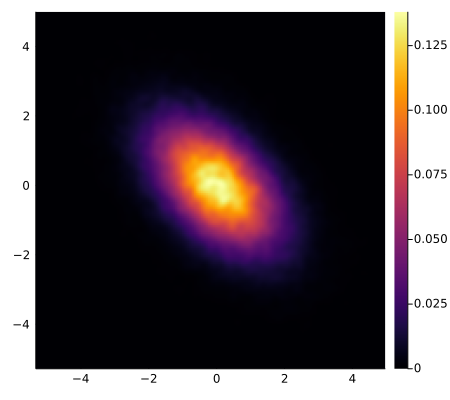

In [6]:
X, Y = first.(sample), last.(sample)
d = InterpKDE(kde((X, Y)))
x, y = range(extrema(X)...; length=201), range(extrema(Y)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400), right_margin=3Plots.mm)

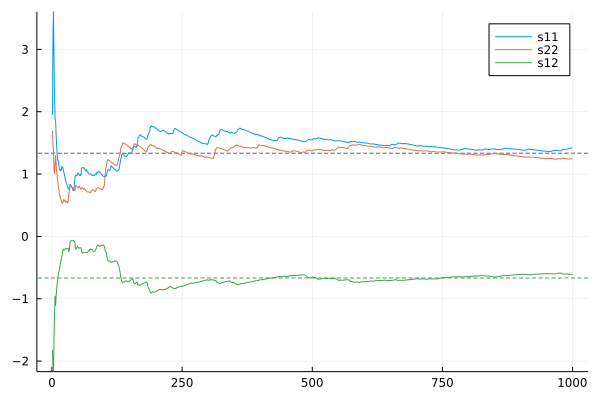

In [7]:
f(n) = mean(x -> x*x', @view sample[1:n])

n = 1:1000
S = f.(n)
S11 = (S -> S[1,1]).(S)
S22 = (S -> S[2,2]).(S)
S12 = (S -> S[1,2]).(S)

ymin = min(-1.5, minimum(S11), minimum(S22), minimum(S12))
ymax = max(2.5, maximum(S11), maximum(S22), maximum(S12))

plot(ylim = (ymin, ymax))
plot!(S11; label="s11", c=1)
hline!([inv(A)[1,1]]; label="", c=1, ls=:dash)
plot!(S22; label="s22", c=2)
hline!([inv(A)[2,2]]; label="", c=2, ls=:dash)
plot!(S12; label="s12", c=3)
hline!([inv(A)[1,2]]; label="", c=3, ls=:dash)

## φ(x) = a(x - 1)²

  0.261643 seconds (654.01 k allocations: 46.088 MiB, 5.80% gc time, 67.28% compilation time)
  0.086735 seconds (14 allocations: 1.526 MiB)
  0.084472 seconds (14 allocations: 1.526 MiB)
  0.093991 seconds (14 allocations: 1.526 MiB)
  0.083569 seconds (14 allocations: 1.526 MiB)
  0.085524 seconds (14 allocations: 1.526 MiB)


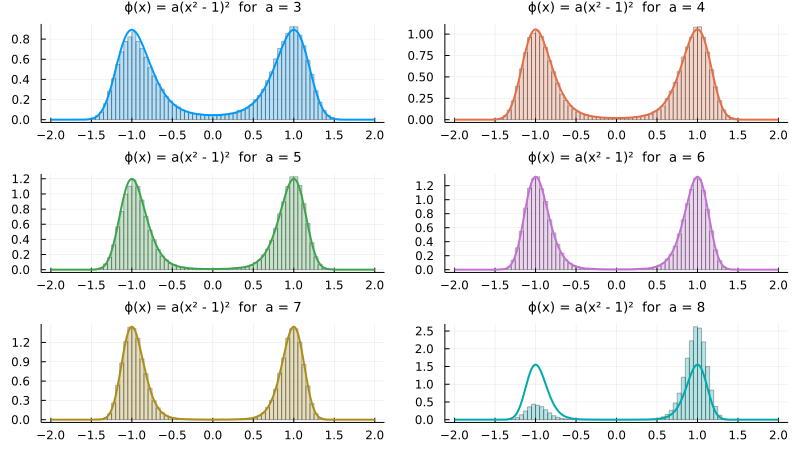

In [8]:
ϕ4(x, a) = a * (x[1]^2 - 1)^2
a = [3, 4, 5, 6, 7, 8]
XX = Vector{Float64}[]
ZZ = Float64[]
PP = []
for i in eachindex(a)
    Z = quadgk(x -> exp(-ϕ4((x,), a[i])), -Inf, Inf)[1]
    push!(ZZ, Z)
    lf = My.LFProblem(1, ϕ4; dt = 0.05, nsteps = 100)
    @time X = first.(My.HMC(lf, a[i]))
    flush(stdout)
    push!(XX, X)
    P = plot()
    histogram!(X; norm=true, alpha=0.3, label="HMC LF sample", bin=100, c=i)
    plot!(x -> exp(-ϕ4(x, a[i]))/Z, -2, 2; label="exp(-ϕ2(x))/Z", lw=2, c=i)
    plot!(; legend=false, xtick=-2:0.5:2)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(PP, P)
end
plot(PP...; size=(800, 450), layout=(3, 2))

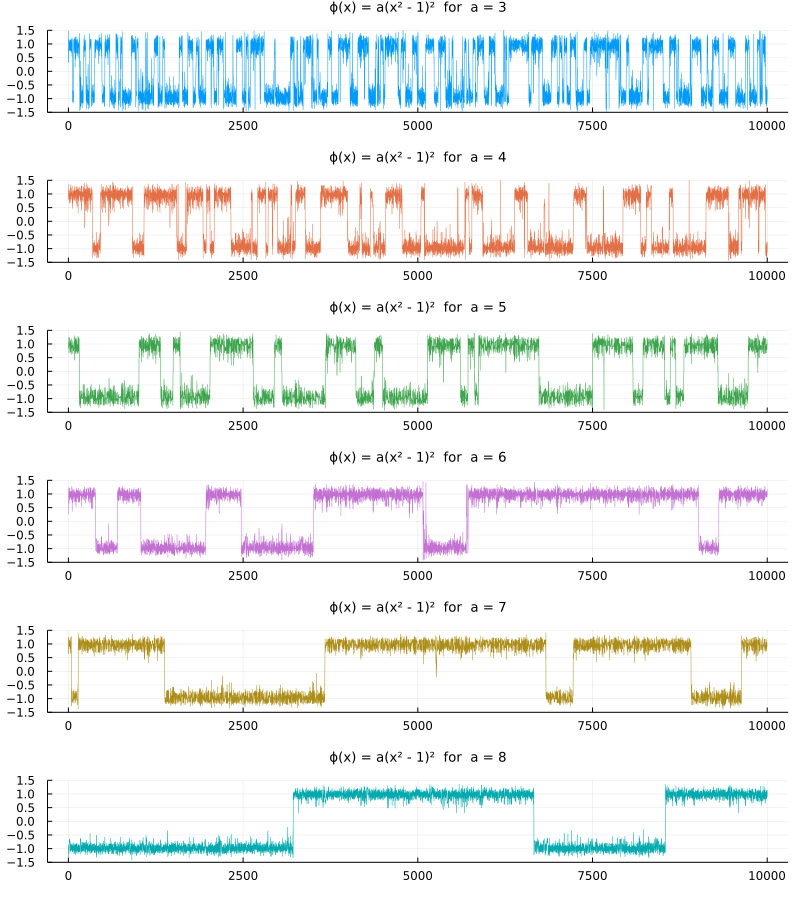

In [9]:
QQ = []
for i in eachindex(a)
    Q = plot(XX[i][1:10000]; ylim=(-1.5, 1.5), label="", c=i, lw=0.5)
    title!("ϕ(x) = a(x² - 1)²  for  a = $(a[i])", titlefontsize=9)
    push!(QQ, Q)
end
plot(QQ...; size=(800, 900), layout=(length(a), 1))

## Baysian inference for a sample of the standard normal distribution

In [10]:
n = 10
sample_normal = randn(n)
f(y, m, s) = (y - m)^2/(2s^2) + log(s)
negloglik(w, sample) = sum(y -> f(y, w[1], exp(w[2])), sample)
lf = My.LFProblem(2, negloglik; dt = 0.1, nsteps = 30)

Main.My.LFProblem{2, typeof(negloglik), Main.My.var"#H#3"{typeof(negloglik)}, Main.My.var"#F#4"{typeof(negloglik)}, Float64, Int64}(negloglik, Main.My.var"#H#3"{typeof(negloglik)}(negloglik), Main.My.var"#F#4"{typeof(negloglik)}(negloglik), 0.1, 30)

In [11]:
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))
@time sample = My.HMC(lf, sample_normal; init = SVector(0.0, 0.0))

  0.872620 seconds (514.35 k allocations: 31.809 MiB, 22.12% compilation time)
  0.678854 seconds (3 allocations: 1.526 MiB)
  0.685986 seconds (3 allocations: 1.526 MiB)


100000-element Vector{SVector{2, Float64}}:
 [0.0988617352056825, 0.05823798742479195]
 [-0.3761673792653133, -0.32849980221739317]
 [0.022963371420081147, -0.17377333125901825]
 [-0.05039675935187472, -0.21754133615200225]
 [0.18743216390593925, -0.15090834999038033]
 [0.49667431884859325, -0.2778381679170763]
 [0.37947845915645007, -0.4985660047667465]
 [0.32324744227131036, -0.45351980555214555]
 [0.5098534417593927, -0.6146137716181159]
 [0.1727911087514289, -0.5300145499627187]
 [0.6072791415610279, -0.4631377914292063]
 [0.12469689003683852, -0.49094221435658875]
 [0.3995678334456574, -0.33903979496990244]
 ⋮
 [0.42062524586233446, -0.5008454363729885]
 [0.26162186231317786, -0.6326177185218346]
 [0.6176642833956255, -0.67052014291641]
 [0.39887656839084207, -0.6974804627378044]
 [0.45210954927608626, -0.47155530154023373]
 [0.7046656965219248, -0.42559146458460784]
 [0.4549466146400971, -0.32703111640891536]
 [0.4076834561282407, -0.5582879227734998]
 [0.41361677511623907, -0.55

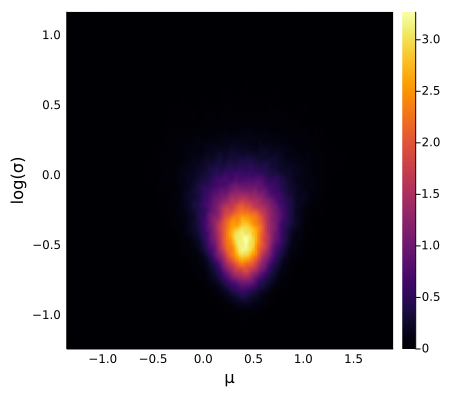

In [12]:
m, logs = first.(sample), last.(sample)
d = InterpKDE(kde((m, logs)))
x, y = range(extrema(m)...; length=201), range(extrema(logs)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400), xlabel="μ", ylabel="log(σ)")

## Symbolics.jl example

In [13]:
dim = 2
@variables a[1:dim, 1:dim], x[1:dim]
aa, xx = collect.((a, x))

(Num[a[1, 1] a[1, 2]; a[2, 1] a[2, 2]], Num[x[1], x[2]])

In [14]:
phi_sym = dot(xx, aa, xx)/2 |> expand |> simplify

((1//2)*a[1, 2] + (1//2)*a[2, 1])*x[1]*x[2] + (1//2)*(x[1]^2)*a[1, 1] + (1//2)*(x[2]^2)*a[2, 2]

In [15]:
dphi_sym = Symbolics.gradient(phi_sym, xx)

2-element Vector{Num}:
 ((1//2)*a[1, 2] + (1//2)*a[2, 1])*x[2] + x[1]*a[1, 1]
 ((1//2)*a[1, 2] + (1//2)*a[2, 1])*x[1] + x[2]*a[2, 2]

In [16]:
phi_rgf = build_function(phi_sym, xx, aa; expression = Val(false))
dphi_rgf = build_function(dphi_sym, xx, aa; expression = Val(false))[1]
lf = My.LFProblem(dim, phi_rgf, dphi_rgf);

In [17]:
param = A = @SMatrix [
     1  1/2
    1/2  1
]

2×2 SMatrix{2, 2, Float64, 4} with indices SOneTo(2)×SOneTo(2):
 1.0  0.5
 0.5  1.0

In [18]:
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param);

  0.180662 seconds (335.61 k allocations: 21.692 MiB, 80.45% compilation time)
  0.037796 seconds (4 allocations: 1.526 MiB)
  0.034205 seconds (4 allocations: 1.526 MiB)


In [19]:
@btime My.HMC($lf, $param);

  32.173 ms (4 allocations: 1.53 MiB)


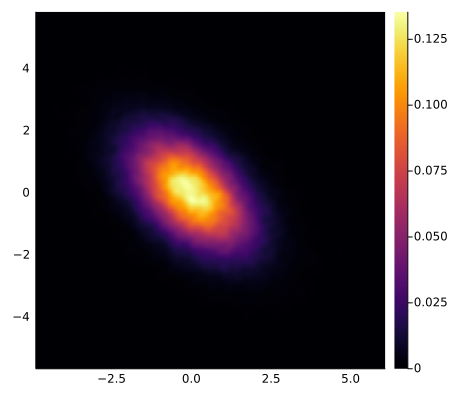

In [20]:
X, Y = first.(sample), last.(sample)
d = InterpKDE(kde((X, Y)))
x, y = range(extrema(X)...; length=201), range(extrema(Y)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400), right_margin=3Plots.mm)

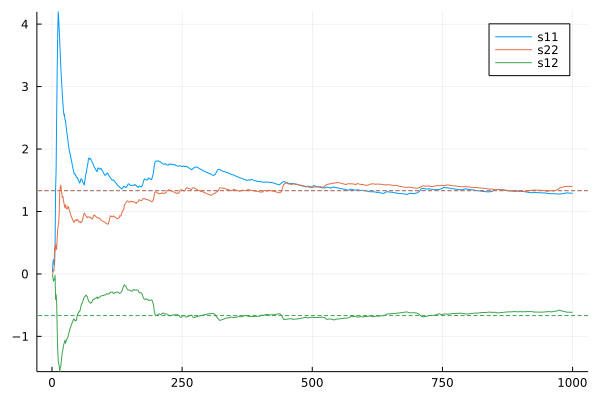

In [21]:
f(n) = mean(x -> x*x', @view sample[1:n])

n = 1:1000
S = f.(n)
S11 = (S -> S[1,1]).(S)
S22 = (S -> S[2,2]).(S)
S12 = (S -> S[1,2]).(S)

ymin = min(-1.5, minimum(S11), minimum(S22), minimum(S12))
ymax = max(2.5, maximum(S11), maximum(S22), maximum(S12))

plot(ylim = (ymin, ymax))
plot!(S11; label="s11", c=1)
hline!([inv(A)[1,1]]; label="", c=1, ls=:dash)
plot!(S22; label="s22", c=2)
hline!([inv(A)[2,2]]; label="", c=2, ls=:dash)
plot!(S12; label="s12", c=3)
hline!([inv(A)[1,2]]; label="", c=3, ls=:dash)